In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *
from scipy.signal import tukey

In [2]:
medium = load_medium_list()
rmed = load_random_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz
 
#0 isotropic
#1 cubic
#2 VTI
#3 tetragonal
#4 trigonal
#5 orthorhombic
#6 monoclinic
#7 triclinic


In [67]:
C, density = get_specific_VTI(medium[1])
#C, density = get_random_C(rmed[7],20)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


### Velocity estimation with SVD

With the tool of Singular Value Decomposition (SVD) it's possible to calculate the average ratio between components. A time window for the average ratio has to be selected around the wavefront arrival.

Seismometer rotated such that $\nu=(1,0,0)^T$:

Velocity estimation:

$
v_{est}(t) = \sqrt{\frac{\ddot u_y^2+\ddot u_z^2}{\dot\Omega_y^2+\dot\Omega_z^2}}
$



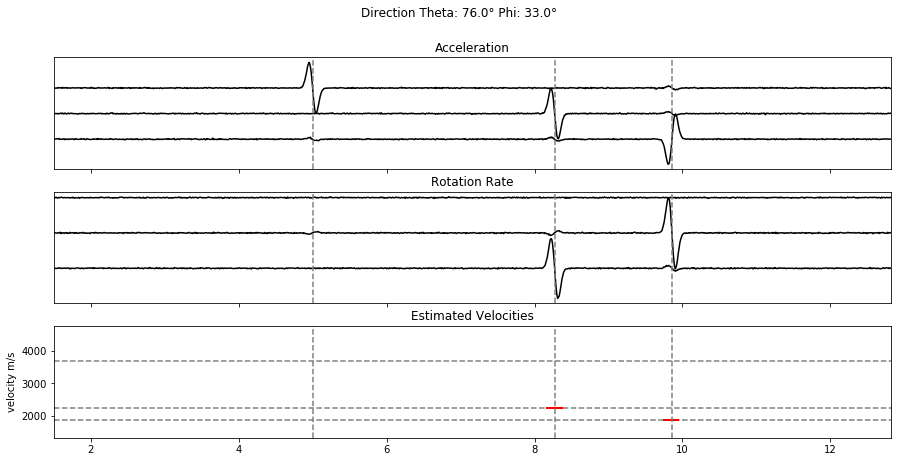

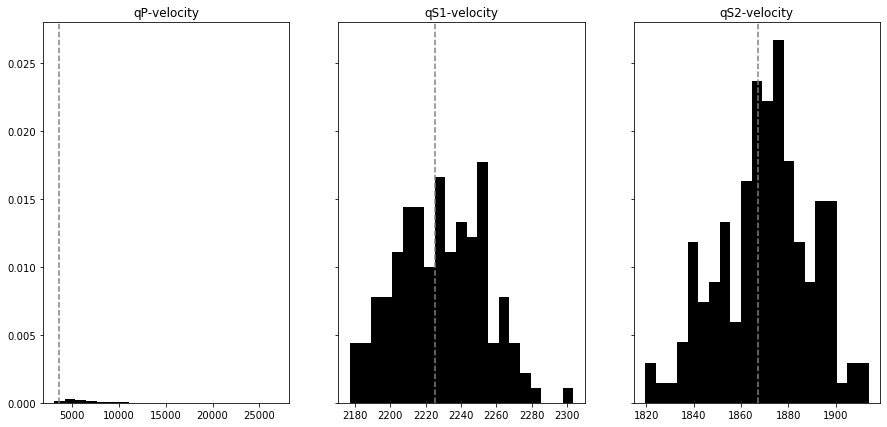

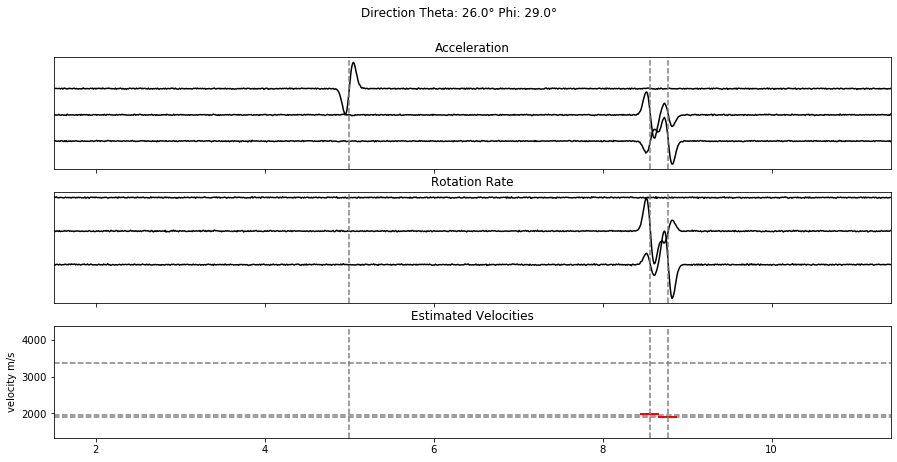

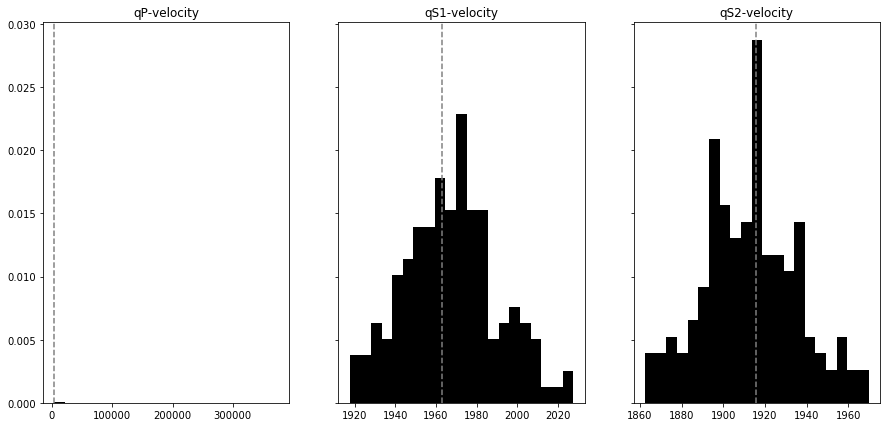

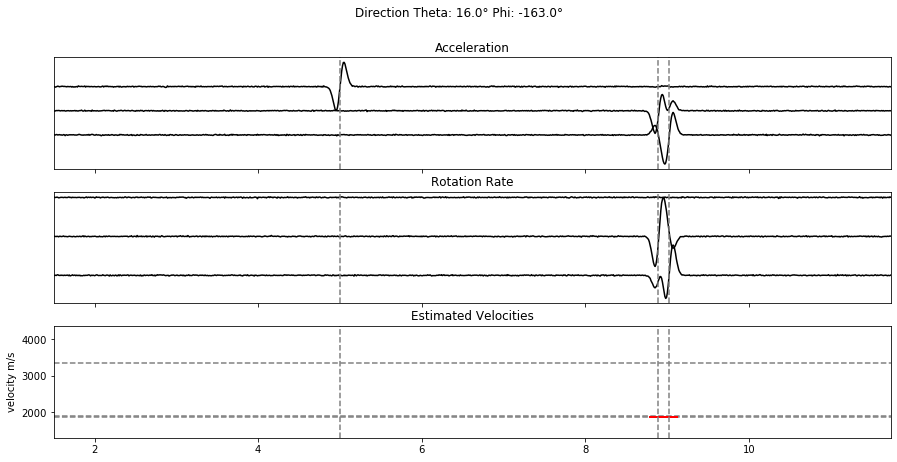

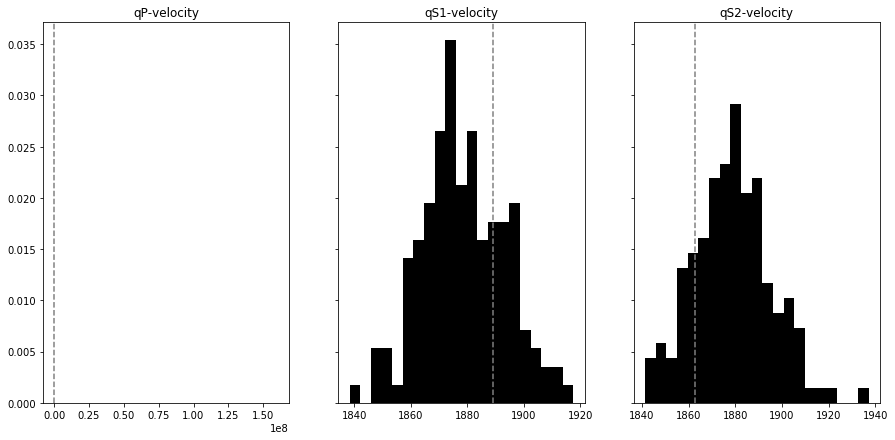

In [73]:
f = 15.
fs = 100.
SNR_dB_u = 20.
SNR_dB_r = 20.
N = 3
Nest = 150
plot1seis = True
hw = [10]
nbins = 21
r2d = 180./np.pi
d2r = 1./r2d
for j in range(0,N):
    nus, gammas = get_direction('random',C,1)
    vel,v = get_eigenvals(gammas[0], density)
    vel_e_all = []
    for i in range(0,len(hw)):
        vel_e = np.zeros((3,Nest))
        for k in range(0,Nest):
            seis, t = get_seis(v, vel, nus[0], f, fs)
            seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
            nt = len(seis[0,:])
            nu_e = get_propagation_direction(seis)
            seis,_ = rotate_seis_around_vector(seis,nu_e)

            iqp = int(np.mean([np.argmax(seis[0,:]),np.argmin(seis[0,:])]))
            iqs1 = int(np.mean([np.argmax(seis[1,:]),np.argmin(seis[1,:])]))
            iqs2 = int(np.mean([np.argmax(seis[2,:]),np.argmin(seis[2,:])]))
            if iqs1>iqs2:
                iqs1,iqs2 = iqs2, iqs1
                
            #helps to separate shear waves properly###########
            safety = 50
            if iqs1>iqs2:
                iqs1,iqs2 = iqs2, iqs1
            elif abs(iqs1-iqs2)<safety:
                angle = 45.
                seis[1,:],seis[2,:] = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:],\
                                      np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]

                iqp = int(np.mean([np.argmax(seis[0,:]),np.argmin(seis[0,:])]))
                iqs1 = int(np.mean([np.argmax(seis[1,:]),np.argmin(seis[1,:])]))
                iqs2 = int(np.mean([np.argmax(seis[2,:]),np.argmin(seis[2,:])]))
                if iqs1>iqs2:
                    iqs1,iqs2 = iqs2, iqs1
            ######################################################    
                
                

            data = np.zeros((nt,2))
            data[:,0] = np.sqrt(seis[1,:]**2+seis[2,:]**2)
            data[:,1] = np.sqrt(seis[4,:]**2+seis[5,:]**2)
            ratio = np.zeros(3)
            ind = [iqp,iqs1,iqs2]
            for it in range(0,3):    
                Cov = np.cov(data[ind[it]-hw[i]:ind[it]+hw[i],:], rowvar=False)
                w, Q = np.linalg.eigh(Cov, UPLO='U')
                loc = np.argsort(np.abs(w))[::-1]
                Q = Q[:,loc]
                ratio[it] = .5 * np.abs(Q[0,0]/Q[1,0])
                vel_e[it,k] = ratio[it]


        if plot1seis:
            a1 = abs(seis[0:3][:].max())
            fig, ax = plt.subplots(nrows=3,figsize=(15,7),sharex=True)
            theta, phi = get_angles(nus[0])
            plt.suptitle('Direction Theta: '+str(round(theta*r2d,0))+'° Phi: '+str(round(phi*r2d,0))+'°')
            ax[0].set_title('Acceleration')
            ax[0].plot(t,seis[0,:],label='x',c='k')
            ax[0].plot(t,seis[1,:]-a1,label='y',c='k')
            ax[0].plot(t,seis[2,:]-2*a1,label='z',c='k')
            ax[0].set_yticks([])
            a2 = seis[3:6][:].max()
            ax[1].set_title('Rotation Rate')
            ax[1].plot(t,seis[3,:],label='rot_x',c='k')
            ax[1].plot(t,seis[4,:]-a2,label='rot_y',c='k')
            ax[1].plot(t,seis[5,:]-2*a2,label='rot_z',c='k')
            ax[1].set_yticks([])

            ax[2].set_title('Estimated Velocities')
            ax[2].axhline(max(vel),color='0.5',linestyle='--')
            ax[2].axhline(np.median(vel),color='0.5',linestyle='--')
            ax[2].axhline(min(vel),color='0.5',linestyle='--')
            ax[2].set_ylabel('velocity m/s')
            ax[2].set_ylim([min(vel)*0.7,max(vel)*1.3])
            ax[0].set_xlim([t[0],t[-1]])
            ax[1].set_xlim([t[0],t[-1]])
            ax[2].set_xlim([t[0],t[-1]])
            ax[2].axhline(ratio[0],xmin = (ind[0]-hw[i])/nt ,xmax = (ind[0]+hw[i])/nt,color='red',linewidth=2)
            ax[2].axhline(ratio[1],xmin = (ind[1]-hw[i])/nt ,xmax = (ind[1]+hw[i])/nt,color='red',linewidth=2)
            ax[2].axhline(ratio[2],xmin = (ind[2]-hw[i])/nt ,xmax = (ind[2]+hw[i])/nt,color='red',linewidth=2)
            for j in range(0,3):
                    ax[j].axvline(t[iqp],color='0.5',linestyle='--')
                    ax[j].axvline(t[iqs1],color='0.5',linestyle='--')
                    ax[j].axvline(t[iqs2],color='0.5',linestyle='--')
            plt.show()


        fig,ax = plt.subplots(ncols=3,figsize=(15,7),sharey=True)
        ax[0].set_title('qP-velocity')
        ax[1].set_title('qS1-velocity')
        ax[2].set_title('qS2-velocity')
        ax[0].hist(vel_e[0,:],bins=nbins,density=True,color='k')
        ax[1].hist(vel_e[1,:],bins=nbins,density=True,color='k')
        ax[2].hist(vel_e[2,:],bins=nbins,density=True,color='k')
        ax[0].axvline(max(vel),color='0.5',linestyle='--')
        ax[1].axvline(np.median(vel),color='0.5',linestyle='--')
        ax[2].axvline(min(vel),color='0.5',linestyle='--')
        vel_e_all.append(vel_e)
        plt.show() 


### Velocity estimation with weights

Dealing with noisy data, it doesn't make sense to only look at one specific point in time to retrieve estimations for velocity, polarizations and propagation directions. Therefore, we can look at a time window and take it's average estimation. The window is chosen such that the components going into the ratio are as high as possible.

Seismometer rotated such that $\nu=(1,0,0)^T$:

Velocity estimation:

$
v_{est}(t) = \sqrt{\frac{\ddot u_y^2+\ddot u_z^2}{\dot\Omega_y^2+\dot\Omega_z^2}}
$

Corresponding Weights:

$
w(t) = \sqrt{(\ddot u_y^2+\ddot u_z^2)(\dot\Omega_y^2+\dot\Omega_z^2)}
$

Next, the arrivals of qP, qS1 and qS2 are picked and each velocity estimation in time can be assigned to the arrival closest to it. 

The time window is picked such that the weight is one magnitude higher than the median of the weight.

Retrieve the velocity estimation this way:

$
v = \frac{\sum_i w_iv_{est,i}}{\sum_i w_i}
$


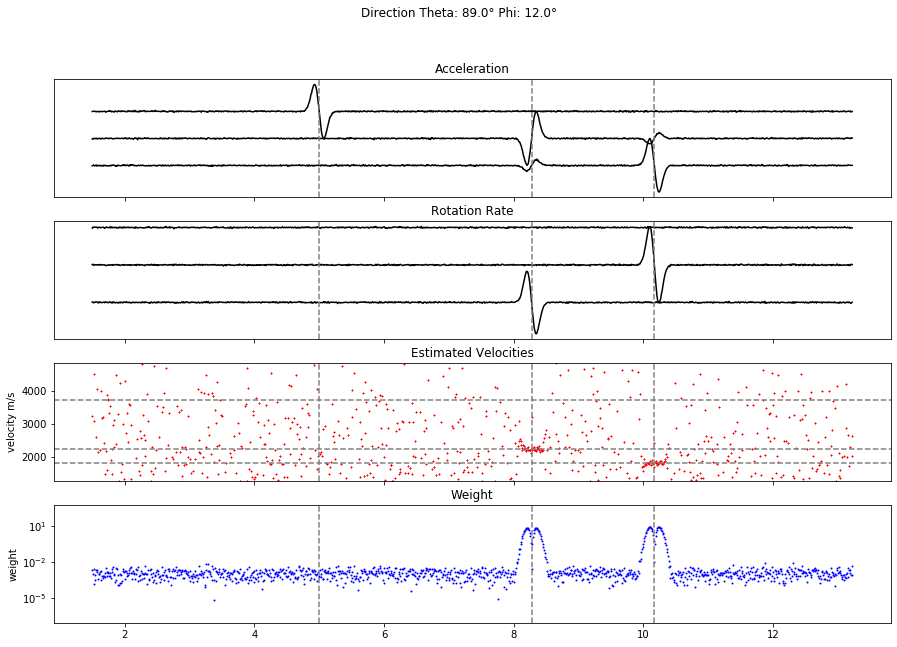

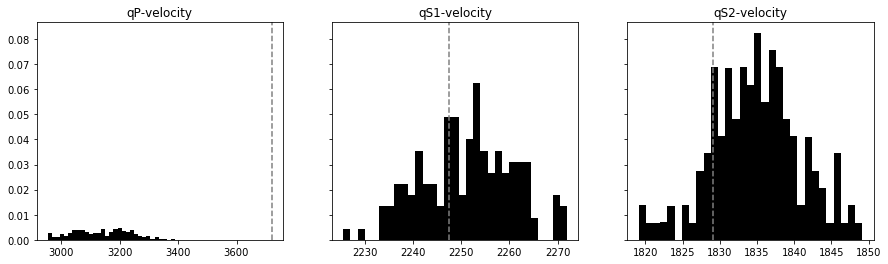

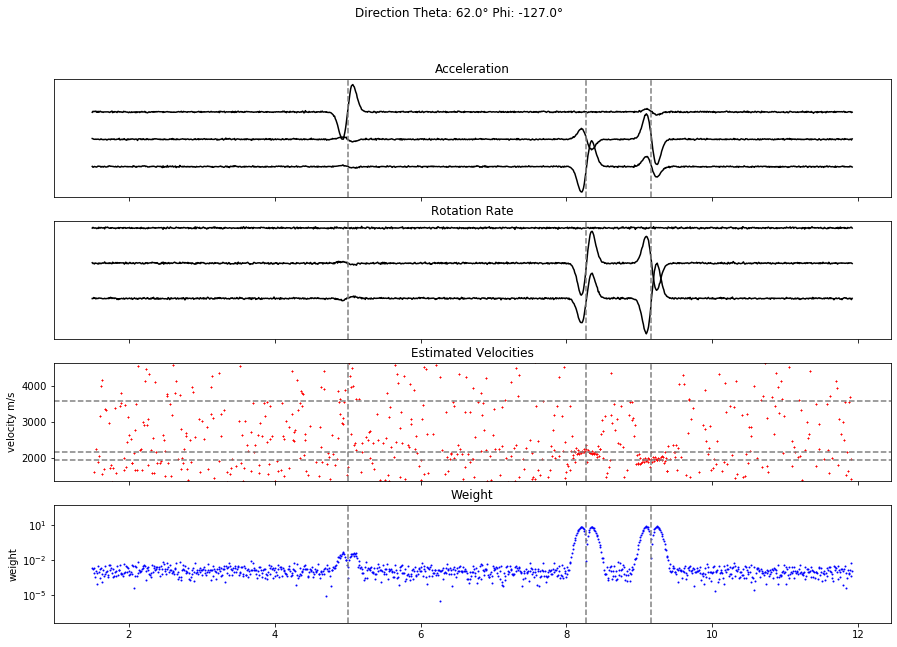

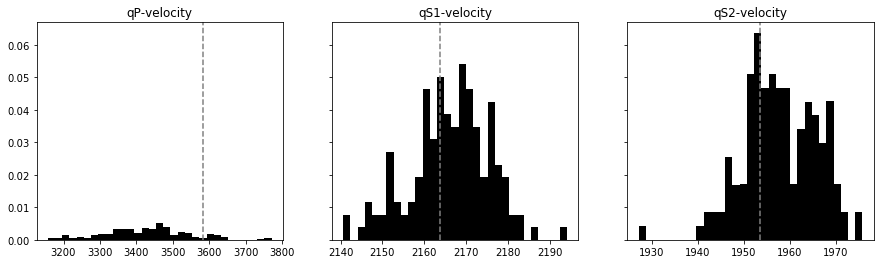

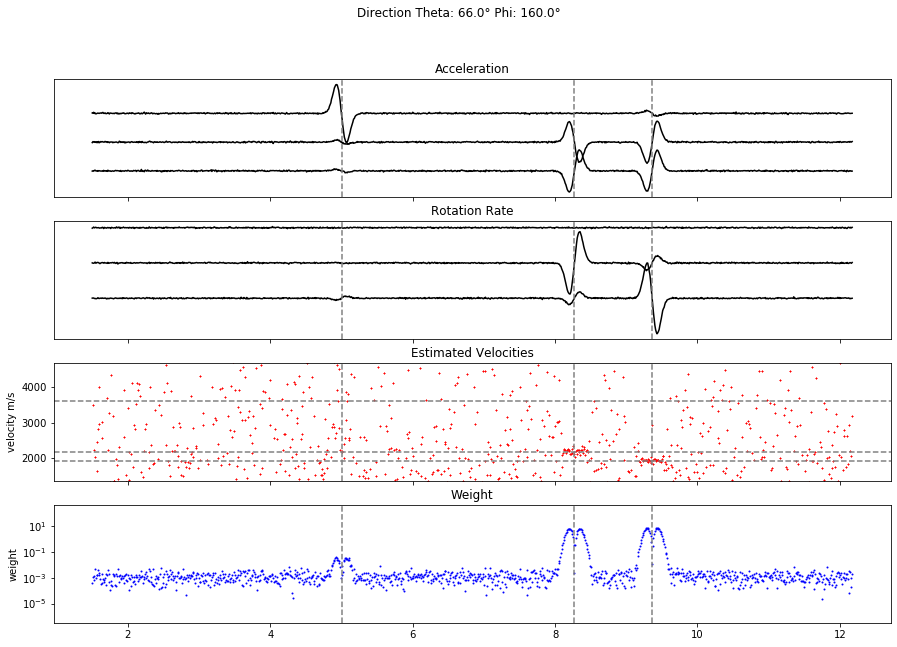

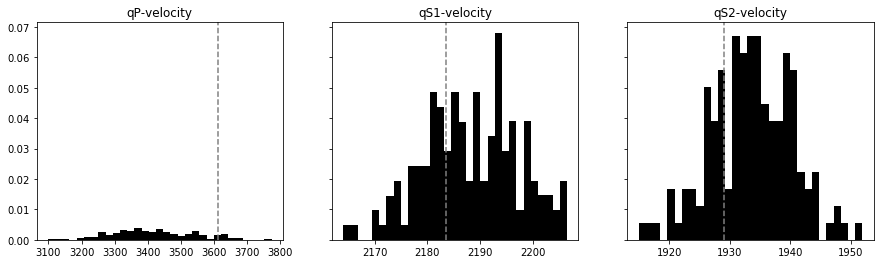

In [74]:
f = 10.
fs = 100.
SNR_dB_u = 20.
SNR_dB_r = 20.
plot1seis = True
plotvelest = True
N = 3
Nest = 150
nbins = 31

r2d = 180/np.pi
for i in range(0,N):
    velhist = np.zeros((Nest,3))
    weighthist = np.zeros((Nest,3))
    nus, gammas = get_direction('random',C,1)
    vel,v = get_eigenvals(gammas[0], density)
    for k in range(0,Nest):
        seis, t = get_seis(v, vel, nus[0], f, fs)
        seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
        nt = len(seis[0,:])
        nu_e = get_propagation_direction(seis)
        seis,_ = rotate_seis_around_vector(seis,nu_e)
        
        nang = 360
        xc  = np.zeros(nang)
        ang = np.linspace(0,180,nang)
        d2r = r2d**-1

        for i in range(nang):
            angle = ang[i]
            xr = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:]
            yr = np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]
            junk = np.corrcoef(xr, yr)
            xc[i] = junk[1,0]
            ang[i] = angle
        
        imax = np.argmax(xc)
        imax2 = np.argmin(xc)
        if abs(imax)<abs(imax2):
            imax = imax2
        amax = ang[imax] + 45.

        angle = amax
        seis[1,:],seis[2,:] = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:],\
                              np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]
        
        iqp = int(np.mean([np.argmax(seis[0,:]),np.argmin(seis[0,:])]))
        iqs1 = int(np.mean([np.argmax(seis[1,:]),np.argmin(seis[1,:])]))
        iqs2 = int(np.mean([np.argmax(seis[2,:]),np.argmin(seis[2,:])]))
        
        safety = 50
        
        if iqs1>iqs2:
            iqs1,iqs2 = iqs2, iqs1
        elif abs(iqs1-iqs2)<safety:
            angle = 45.
            seis[1,:],seis[2,:] = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:],\
                                  np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]

            iqp = int(np.mean([np.argmax(seis[0,:]),np.argmin(seis[0,:])]))
            iqs1 = int(np.mean([np.argmax(seis[1,:]),np.argmin(seis[1,:])]))
            iqs2 = int(np.mean([np.argmax(seis[2,:]),np.argmin(seis[2,:])]))
            if iqs1>iqs2:
                iqs1,iqs2 = iqs2, iqs1
            
                        
        vel_e = 1/2. * np.sqrt(seis[1,:]**2+seis[2,:]**2)/np.sqrt(seis[4,:]**2+seis[5,:]**2)
        weight = np.sqrt(seis[1,:]**2+seis[2,:]**2) * np.sqrt(seis[4,:]**2+seis[5,:]**2)
        
        if k==0 and plot1seis:
            a1 = abs(seis[0:3][:].max())
            fig, ax = plt.subplots(nrows=4,figsize=(15,10),sharex=True)
            theta, phi = get_angles(nus[0])
            plt.suptitle('Direction Theta: '+str(round(theta*r2d,0))+'° Phi: '+str(round(phi*r2d,0))+'°')
            ax[0].set_title('Acceleration')
            ax[0].plot(t,seis[0,:],label='x',c='k')
            ax[0].plot(t,seis[1,:]-a1,label='y',c='k')
            ax[0].plot(t,seis[2,:]-2*a1,label='z',c='k')
            ax[0].set_yticks([])
            a2 = seis[3:6][:].max()
            ax[1].set_title('Rotation Rate')
            ax[1].plot(t,seis[3,:],label='rot_x',c='k')
            ax[1].plot(t,seis[4,:]-a2,label='rot_y',c='k')
            ax[1].plot(t,seis[5,:]-2*a2,label='rot_z',c='k')
            ax[1].set_yticks([])

            ax[2].set_title('Estimated Velocities')

            ax[2].axhline(max(vel),color='0.5',linestyle='--')
            ax[2].axhline(np.median(vel),color='0.5',linestyle='--')
            ax[2].axhline(min(vel),color='0.5',linestyle='--')
            ax[2].set_ylabel('velocity m/s')
            ax[2].set_ylim([min(vel)*0.7,max(vel)*1.3])
        wm = np.median(weight)
        velbins = [[],[],[]]
        weightbins = [[],[],[]]
        for it in range(nt):
            if weight[it]>0.:#wm*10.**(1.):  # 1 order of magnitude above median
                if k==0 and plot1seis:
                    ax[2].scatter(t[it],vel_e[it],1,marker='x',color='red')
                ivel = np.argmin([abs(it-iqp),abs(it-iqs1),abs(it-iqs2)])
                velbins[ivel].append(vel_e[it])
                weightbins[ivel].append(weight[it])
        
        if k==0 and plot1seis:            
            ax[3].set_title('Weight')
            ax[3].set_yscale('log')
            ax[3].scatter(t,weight,1,color='blue')
            ax[3].set_ylabel('weight')
            for j in range(0,4):
                    ax[j].axvline(t[iqp],color='0.5',linestyle='--')
                    ax[j].axvline(t[iqs1],color='0.5',linestyle='--')
                    ax[j].axvline(t[iqs2],color='0.5',linestyle='--') 
            plt.savefig('velocity_estimation_time.png')        
            plt.show() 
        
        for j in range(0,3):
            if len(velbins[j])!=0:
                w = np.sum(weightbins[j])
                for jj in range(0,len(velbins[j])):
                    velhist[k,j] += 1./w * weightbins[j][jj] * velbins[j][jj]
                weighthist[k,j] = w          
    if plotvelest:    
        fig,ax = plt.subplots(ncols=3,figsize=(15,4),sharey=True)
        ax[0].set_title('qP-velocity')
        ax[1].set_title('qS1-velocity')
        ax[2].set_title('qS2-velocity')
        ax[0].hist(velhist[:,0],bins=nbins,density=True,color='k',weights=weighthist[:,0])
        ax[1].hist(velhist[:,1],bins=nbins,density=True,color='k',weights=weighthist[:,1])
        ax[2].hist(velhist[:,2],bins=nbins,density=True,color='k',weights=weighthist[:,2])
        ax[0].axvline(max(vel),color='0.5',linestyle='--')
        ax[1].axvline(np.median(vel),color='0.5',linestyle='--')
        ax[2].axvline(min(vel),color='0.5',linestyle='--')
        plt.savefig('velocity_estimation_histogram.png')
        plt.show()
            

### Inversion with weights

In [8]:
C,density = get_specific_VTI(medium[1])
#C, density = get_random_C(rmed[5],30)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


In [9]:
f = 15.
fs = 100.
SNR_dB_u = 20.
SNR_dB_r = 20.
N = 25
Ninv = 150

ang1 = 10.
ang2 = 0.
ang3 = 0.

C = rotate_C(C,1,ang1)
C = rotate_C(C,2,ang2)
C = rotate_C(C,3,ang3)

C_e = np.zeros((Ninv,6,6))
r2d = 180/np.pi
mode = 'triclinic'
sucinv = 0
for k in range(0,Ninv):
    nus, gammas = get_direction('random',C,N)
    d = np.array([])
    G = np.array([])
    count = 0
    Wl = []
    for i in range(0,N):
        vel,v = get_eigenvals(gammas[i], density)
        seis, t = get_seis(v, vel, nus[i], f, fs)
        seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
        nt = len(seis[0,:])
        #seis = lowpass(seis,f,fs)
        nu_e = get_propagation_direction(seis)
        n_trans = get_polarizations(seis,'nav')
        seis,_ = rotate_seis_around_vector(seis,nu_e)
        vel_e = np.zeros(3)
        vel_w = np.zeros(3)
        nang = 360
        xc  = np.zeros(nang)
        ang = np.linspace(0,180,nang)
        d2r = r2d**-1
        
        for j in range(nang):
            angle = ang[i]
            xr = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:]
            yr = np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]
            junk = np.corrcoef(xr, yr)
            xc[i] = junk[1,0]
            ang[i] = angle

        imax = np.argmax(xc)
        imax2 = np.argmin(xc)
        if abs(imax)<abs(imax2):
            imax = imax2
        amax = ang[imax]

        angle = amax
        seis[1,:],seis[2,:] = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:],\
                              np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]

        iqp = int(np.mean([np.argmax(seis[0,:]),np.argmin(seis[0,:])]))
        iqs1 = int(np.mean([np.argmax(seis[1,:]),np.argmin(seis[1,:])]))
        iqs2 = int(np.mean([np.argmax(seis[2,:]),np.argmin(seis[2,:])]))
        if iqs1>iqs2:
            iqs1,iqs2 = iqs2, iqs1
            
        ### helps to separate shear waves properly###########
        safety = 50
        if iqs1>iqs2:
            iqs1,iqs2 = iqs2, iqs1
        elif abs(iqs1-iqs2)<safety:
            angle = 45.
            seis[1,:],seis[2,:] = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:],\
                                  np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]

            iqp = int(np.mean([np.argmax(seis[0,:]),np.argmin(seis[0,:])]))
            iqs1 = int(np.mean([np.argmax(seis[1,:]),np.argmin(seis[1,:])]))
            iqs2 = int(np.mean([np.argmax(seis[2,:]),np.argmin(seis[2,:])]))
            if iqs1>iqs2:
                iqs1,iqs2 = iqs2, iqs1
        ######################################################
        
        ratio = 1/2. * np.sqrt(seis[1,:]**2+seis[2,:]**2)/np.sqrt(seis[4,:]**2+seis[5,:]**2)
        weight = np.sqrt(seis[1,:]**2+seis[2,:]**2) * np.sqrt(seis[4,:]**2+seis[5,:]**2)
        wm = np.median(weight)
        velbins = [[],[],[]]
        weightbins = [[],[],[]]
        for it in range(nt):
            if weight[it]>(wm*10.):  # 1 order of magnitude above median
                ivel = np.argmin([abs(it-iqp),abs(it-iqs1),abs(it-iqs2)])
                velbins[ivel].append(ratio[it])
                weightbins[ivel].append(weight[it]) 

        for j in range(0,3):
            if len(velbins[j])!=0:
                w = np.sum(weightbins[j])
                for jj in range(0,len(velbins[j])):
                    vel_e[j] += 1./w * weightbins[j][jj] * velbins[j][jj]
                vel_w[j] = w 

        if vel_w[0]>0. and vel_e[0]<3*vel_e[1] and vel_e[0]<3*vel_e[2] and vel_w[2]>0. and vel_w[1]>0.:
            count += 1 
            d,G = add_new_data(mode,d,G,nu_e,vel_e,n_trans,density)
            Wl.append(vel_w[0])

    if count>=6:
        sucinv += 1 
        W = np.identity(6*count)
        for ii in range(0,count):
            for ij in range(0,6):
                W[ii+ij,ii+ij] *= Wl[ii]
        Q = np.linalg.inv(np.dot(G.transpose(),G)) 
        #Q = np.linalg.inv(np.dot(np.dot(G.transpose(),W),G))
        m = np.dot(np.dot(Q,G.transpose()),d)
        #m = np.dot(np.dot(np.dot(Q,G.transpose()),W),d)
        C_e[k,:,:] = sort_elastic_coeff(mode,m) 
        if np.sum(C_e[k,:,:]**2)*1e-18>1e6:
            print('index '+str(k)+' failed')
            C_e[k,:,:] = np.zeros((6,6))
print(sucinv, 'successful inversions')    

index 29 failed


C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:1222: RuntimeWarning: divide by zero encountered in double_scalars
  n2 *= 1/np.sqrt(np.sum(n2**2))
C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:1222: RuntimeWarning: invalid value encountered in multiply
  n2 *= 1/np.sqrt(np.sum(n2**2))


150 successful inversions


2 estimates stripped


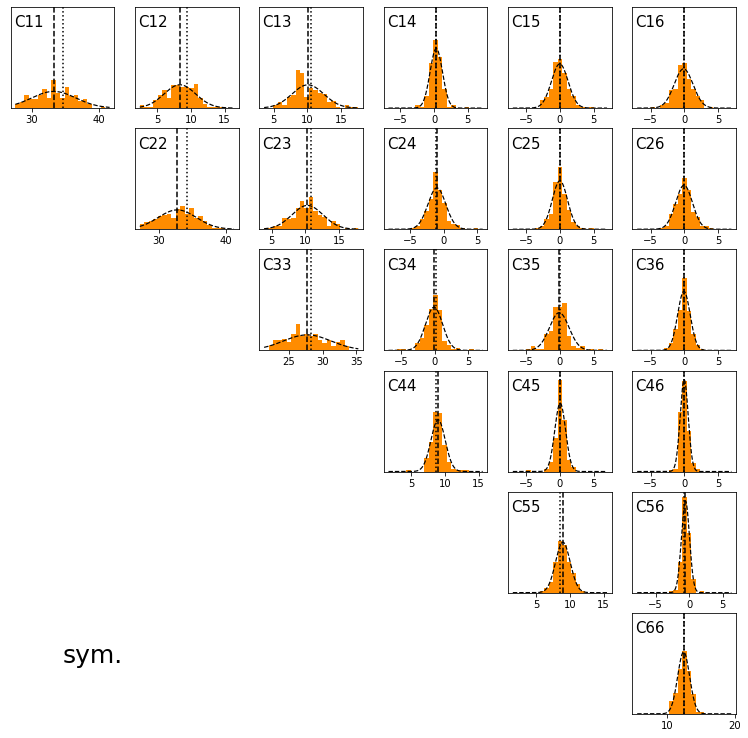

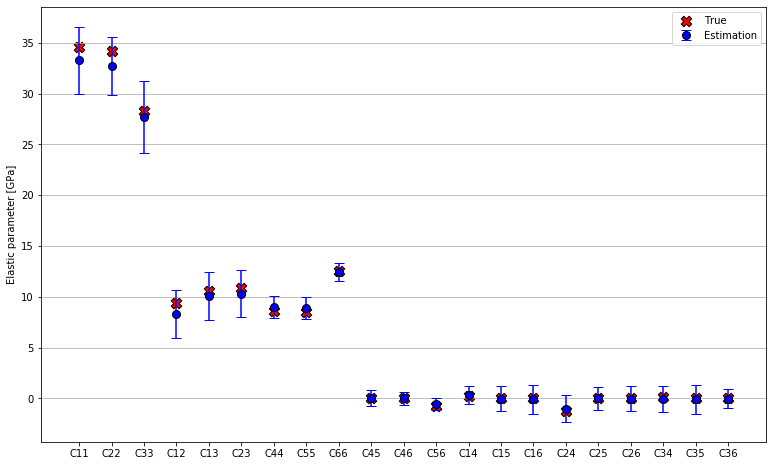

In [10]:
triangularplot(C,C_e,21,7,Ninv,False,savename='TaylorStone_10_5')

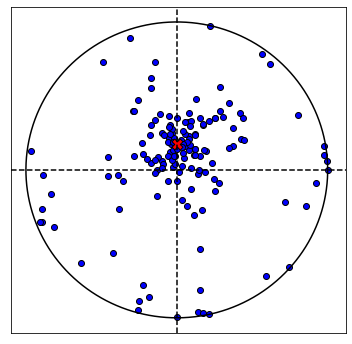

In [18]:
d2r = np.pi/180
bedding = np.zeros((sucinv,3))
angles = np.linspace(0,2*np.pi,1000)
x = np.cos(angles)
y = np.sin(angles)
fig = plt.figure(figsize=(6,6))
real = np.zeros(3)
real[0] = -np.cos(-ang1*d2r)*np.sin(-ang2*d2r)*np.cos(-ang3*d2r)-np.sin(-ang1*d2r)*np.sin(-ang3*d2r)
real[1] = np.cos(-ang1*d2r)*np.sin(-ang2*d2r)*np.sin(-ang3*d2r)-np.sin(-ang1*d2r)*np.cos(-ang3*d2r)
real[2] = np.cos(-ang1*d2r)*np.cos(-ang2*d2r)
for i in range(0,sucinv):
    try:
        Crot,g = getrotationVTI(C_e[i,:,:])
        bedding[i,:] = np.dot(g.transpose(),np.array([0,0,1]))
        if bedding[i,2]<0.:
            bedding[i,:] *= -1.
        plt.scatter(bedding[i,0],bedding[i,1],color='blue',edgecolors='k')
    except:
        pass

plt.scatter(real[0],real[1],120,marker='X',color='red',edgecolors='k')
plt.plot(x,y,color='black')
plt.axvline(0,color='black',ls='--')
plt.axhline(0,color='black',ls='--')
plt.yticks([])
plt.xticks([])
plt.show()

### Inversion with SVD

In [54]:
C,density = get_specific_VTI(medium[1])
#C, density = get_random_C(rmed[5],30)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


In [65]:
f = 15.
fs = 100.
SNR_dB_u = 20.
SNR_dB_r = 20.
N = 20
Ninv = 75
hw = 20

ang1 = 0.
ang2 = 0.
ang3 = 0.

C = rotate_C(C,1,ang1)
C = rotate_C(C,2,ang2)
C = rotate_C(C,3,ang3)

C_e = np.zeros((Ninv,6,6))
r2d = 180/np.pi
mode = 'triclinic'
sucinv = 0
for k in range(0,Ninv):
    nus, gammas = get_direction('random',C,N)
    d = np.array([])
    G = np.array([])
    count = 0
    Wl = []
    for i in range(0,N):
        vel,v = get_eigenvals(gammas[i], density)
        seis, t = get_seis(v, vel, nus[i], f, fs)
        seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r)
        nt = len(seis[0,:])
        #seis = lowpass(seis,f,fs)
        nu_e = get_propagation_direction(seis)
        n_trans = get_polarizations(seis,'nav')
        seis,_ = rotate_seis_around_vector(seis,nu_e)
        vel_e = np.zeros(3)
        vel_w = np.zeros(3)
        nang = 360
        xc  = np.zeros(nang)
        ang = np.linspace(0,180,nang)
        d2r = r2d**-1
        
        for j in range(nang):
            angle = ang[i]
            xr = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:]
            yr = np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]
            junk = np.corrcoef(xr, yr)
            xc[i] = junk[1,0]
            ang[i] = angle

        imax = np.argmax(xc)
        imax2 = np.argmin(xc)
        if abs(imax)<abs(imax2):
            imax = imax2
        amax = ang[imax]

        angle = amax
        seis[1,:],seis[2,:] = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:],\
                              np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]

        iqp = int(np.mean([np.argmax(seis[0,:]),np.argmin(seis[0,:])]))
        iqs1 = int(np.mean([np.argmax(seis[1,:]),np.argmin(seis[1,:])]))
        iqs2 = int(np.mean([np.argmax(seis[2,:]),np.argmin(seis[2,:])]))
        if iqs1>iqs2:
            iqs1,iqs2 = iqs2, iqs1
            
        ### helps to separate shear waves properly###########
        safety = 50
        if iqs1>iqs2:
            iqs1,iqs2 = iqs2, iqs1
        elif abs(iqs1-iqs2)<safety:
            angle = 45.
            seis[1,:],seis[2,:] = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:],\
                                  np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]

            iqp = int(np.mean([np.argmax(seis[0,:]),np.argmin(seis[0,:])]))
            iqs1 = int(np.mean([np.argmax(seis[1,:]),np.argmin(seis[1,:])]))
            iqs2 = int(np.mean([np.argmax(seis[2,:]),np.argmin(seis[2,:])]))
            if iqs1>iqs2:
                iqs1,iqs2 = iqs2, iqs1
        ######################################################
        
        data = np.zeros((nt,2))
        data[:,0] = np.sqrt(seis[1,:]**2+seis[2,:]**2)
        data[:,1] = np.sqrt(seis[4,:]**2+seis[5,:]**2)
        vel_e = np.zeros(3)
        ind = [iqp,iqs1,iqs2]
        for it in range(0,3):    
            Cov = np.cov(data[ind[it]-hw:ind[it]+hw,:], rowvar=False)
            w, Q = np.linalg.eigh(Cov, UPLO='U')
            loc = np.argsort(np.abs(w))[::-1]
            Q = Q[:,loc]
            vel_e[it] = .5 * np.abs(Q[0,0]/Q[1,0])
 
        if vel_e[0]>vel_e[1] and vel_e[0]<vel_e[1]*3.:
            count += 1
            d,G = add_new_data(mode,d,G,nu_e,vel_e,n_trans,density)
    if count>=6:
        sucinv += 1 
        Q = np.linalg.inv(np.dot(G.transpose(),G)) 
        m = np.dot(np.dot(Q,G.transpose()),d)
        C_e[k,:,:] = sort_elastic_coeff(mode,m)
        if np.sum(C_e[k,:,:]**2)*1e-18>1e6:
            print('index '+str(k)+' failed')
            C_e[k,:,:] = np.zeros((6,6))
print(sucinv, 'successful inversions')

Error in get_angles().
75 successful inversions


0 estimates stripped


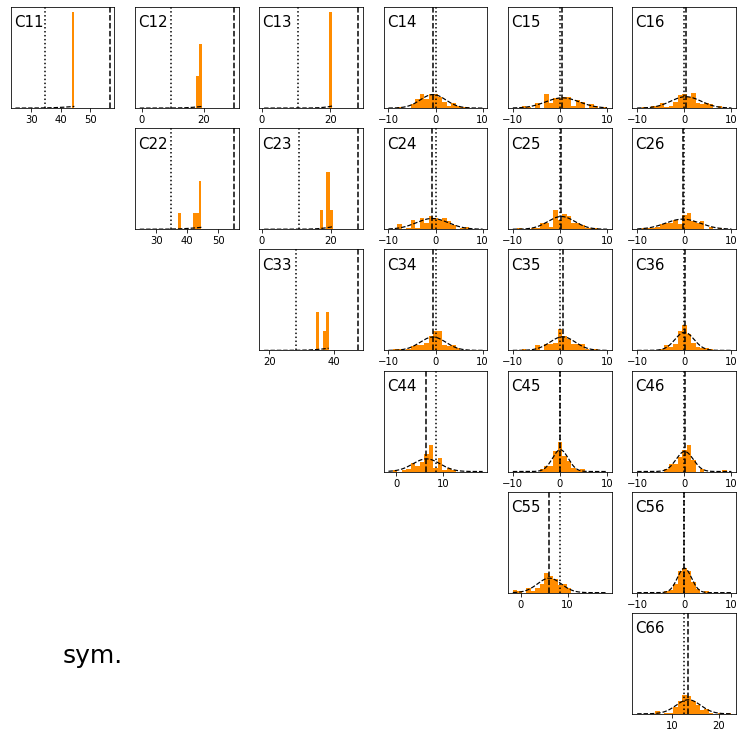

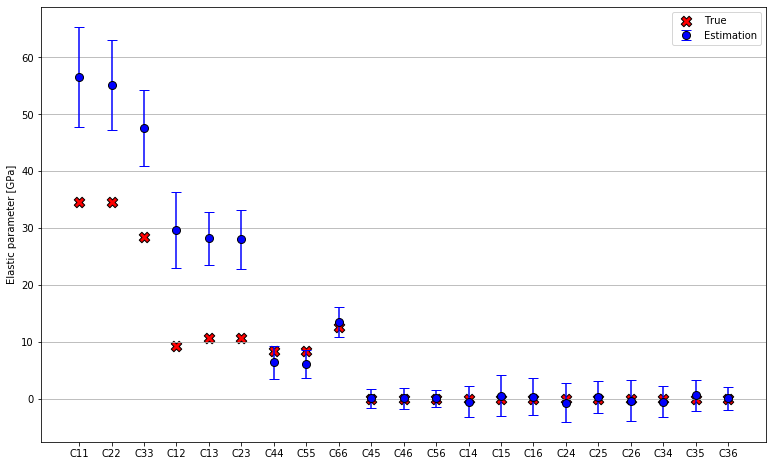

In [66]:
triangularplot(C,C_e,21,10,Ninv,False,savename='TaylorStone_10_5')

## 7C

In [19]:
C,density = get_specific_VTI(medium[1])
#C, density = get_random_C(rmed[5],30)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


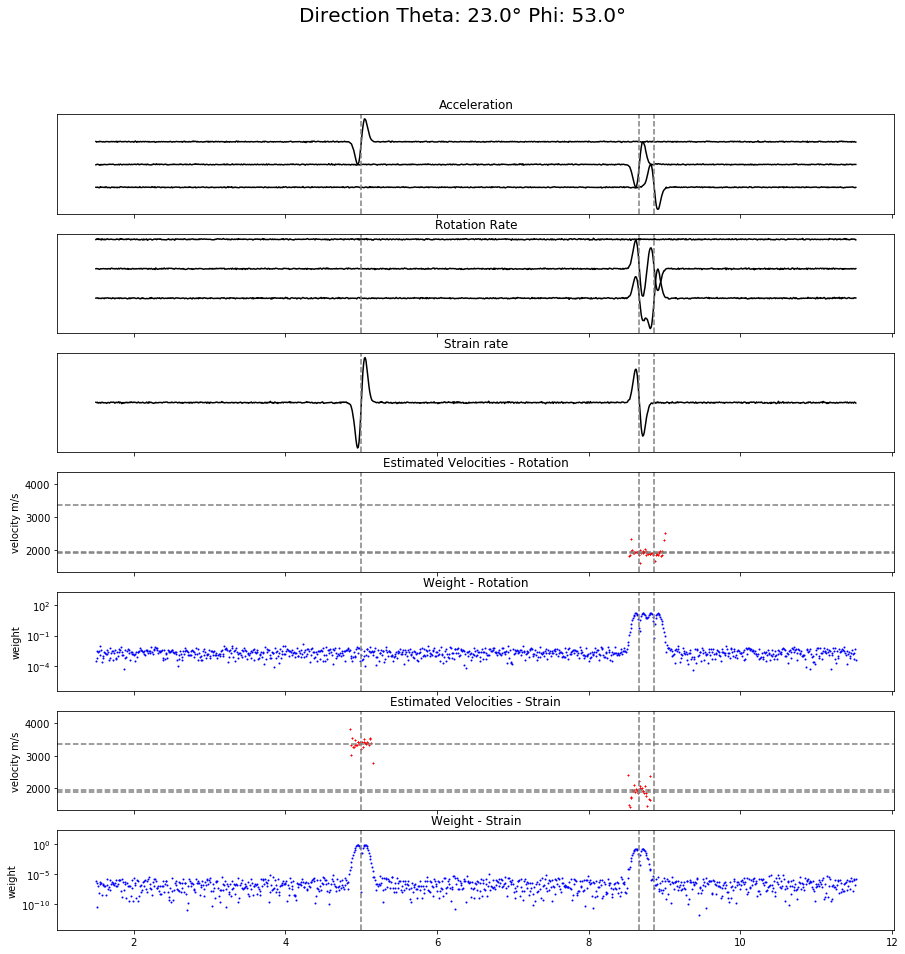

C:\Users\sebi\Anaconda3\envs\obspy\lib\site-packages\numpy\lib\histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


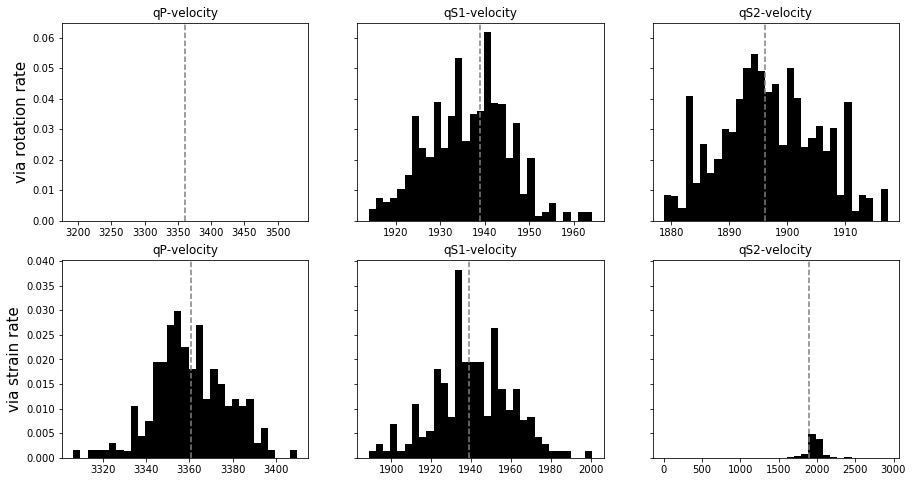

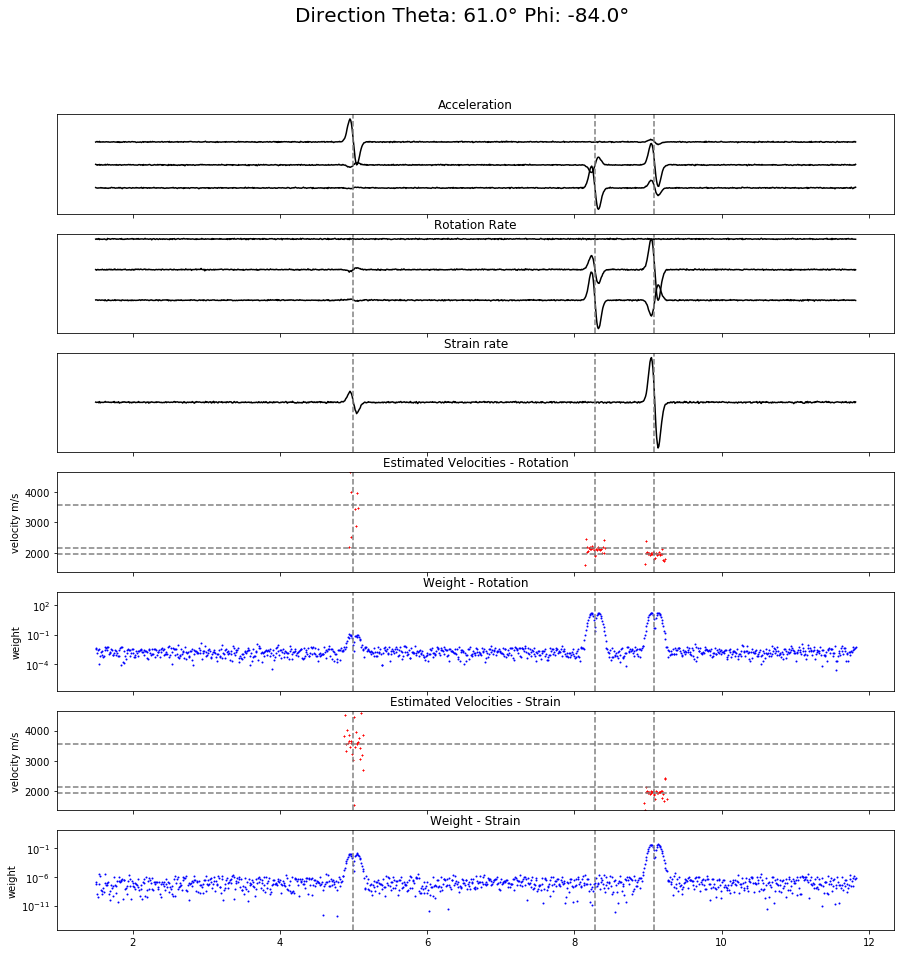

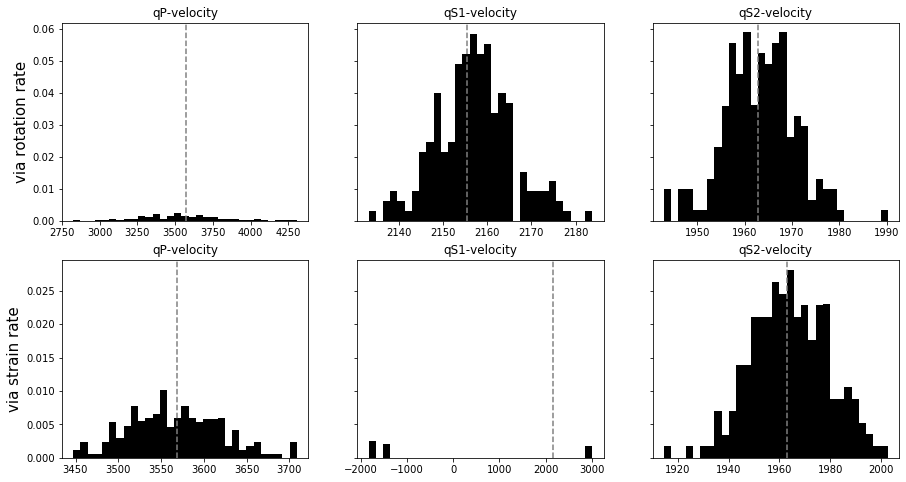

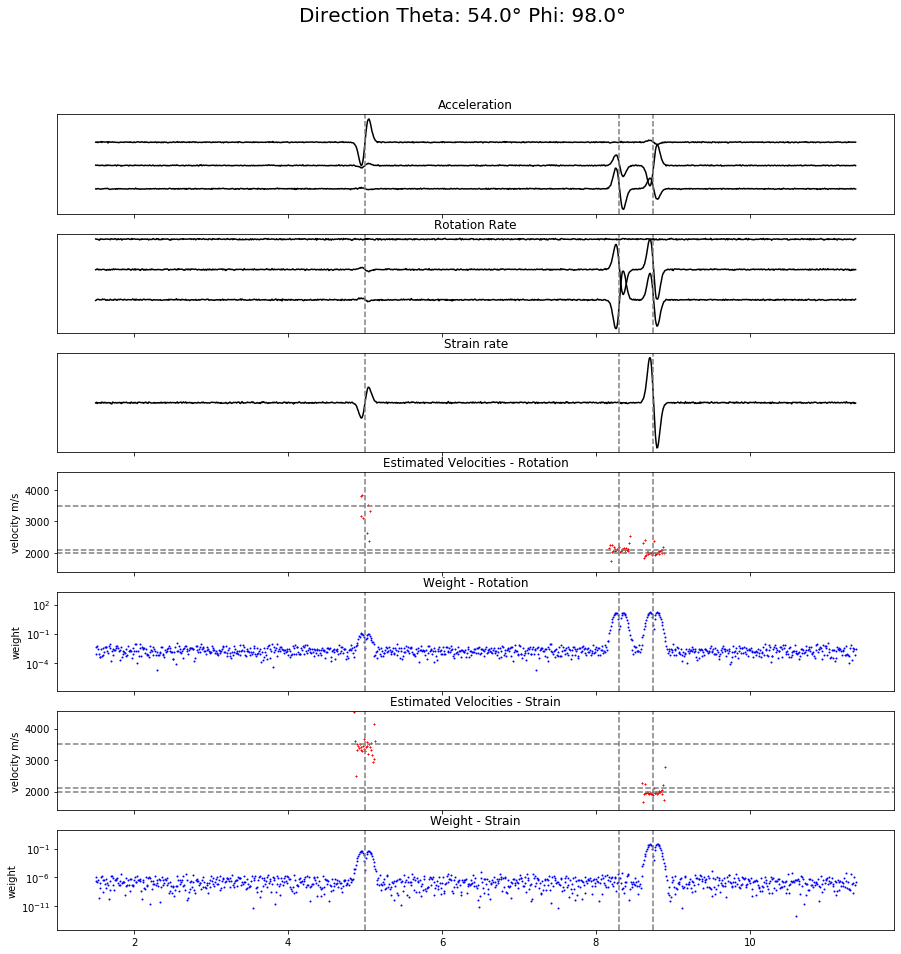

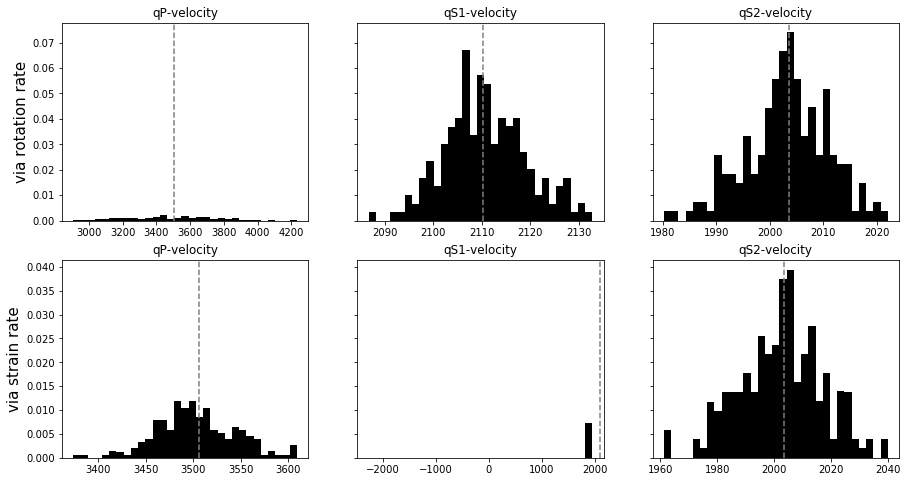

In [21]:
f = 15.
fs = 100.
SNR_dB_u = 20.
SNR_dB_r = 20.
SNR_dB_s = 20.
plot1seis = True
plotvelest = True
N = 3
Nest = 200
nbins = 31

r2d = 180/np.pi
for i in range(0,N):
    velhist = np.zeros((Nest,3))
    velhist_strain = np.zeros((Nest,3))
    weighthist = np.zeros((Nest,3))
    weighthist_strain = np.zeros((Nest,3))
    nus, gammas = get_direction('random',C,1)
    vel,v = get_eigenvals(gammas[0], density)
    for k in range(0,Nest):
        seis, t = get_seis_strain(v, vel, nus[0], f, fs)
        seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s=SNR_dB_s)
        seis = np.array([seis[0,:],seis[1,:],seis[2,:],seis[3,:],seis[4,:],seis[5,:],seis[8,:]])
        nt = len(seis[0,:])
        nu_e = get_propagation_direction(seis)
        vel_e_strain = seis[2,:] / seis[6,:] * nu_e[2]
        weight_strain = abs(seis[2,:] * seis[6,:]**2 * nu_e[2])
        strain_trace = seis[6,:]
        seis,_ = rotate_seis_around_vector(seis,nu_e)
        
        nang = 360
        xc  = np.zeros(nang)
        ang = np.linspace(0,180,nang)
        d2r = r2d**-1

        for i in range(nang):
            angle = ang[i]
            xr = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:]
            yr = np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]
            junk = np.corrcoef(xr, yr)
            xc[i] = junk[1,0]
            ang[i] = angle
        
        imax = np.argmax(xc)
        imax2 = np.argmin(xc)
        if abs(imax)<abs(imax2):
            imax = imax2
        amax = ang[imax] + 45.

        angle = amax
        seis[1,:],seis[2,:] = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:],\
                              np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]
        
        iqp = int(np.mean([np.argmax(seis[0,:]),np.argmin(seis[0,:])]))
        iqs1 = int(np.mean([np.argmax(seis[1,:]),np.argmin(seis[1,:])]))
        iqs2 = int(np.mean([np.argmax(seis[2,:]),np.argmin(seis[2,:])]))
        
        safety = 50
        
        if iqs1>iqs2:
            iqs1,iqs2 = iqs2, iqs1
        elif abs(iqs1-iqs2)<safety:
            angle = 45.
            seis[1,:],seis[2,:] = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:],\
                                  np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]

            iqp = int(np.mean([np.argmax(seis[0,:]),np.argmin(seis[0,:])]))
            iqs1 = int(np.mean([np.argmax(seis[1,:]),np.argmin(seis[1,:])]))
            iqs2 = int(np.mean([np.argmax(seis[2,:]),np.argmin(seis[2,:])]))
            if iqs1>iqs2:
                iqs1,iqs2 = iqs2, iqs1
            
                        
        vel_e = 1/2. * np.sqrt(seis[1,:]**2+seis[2,:]**2)/np.sqrt(seis[4,:]**2+seis[5,:]**2)
        weight = np.sqrt(seis[1,:]**2+seis[2,:]**2) * np.sqrt(seis[4,:]**2+seis[5,:]**2)
        
        if k==0 and plot1seis:
            a1 = abs(seis[0:3][:].max())
            fig, ax = plt.subplots(nrows=7,figsize=(15,15),sharex=True)
            theta, phi = get_angles(nus[0])
            plt.suptitle('Direction Theta: '+str(round(theta*r2d,0))+'° Phi: '+str(round(phi*r2d,0))+'°',fontsize=20)
            ax[0].set_title('Acceleration')
            ax[0].plot(t,seis[0,:],label='x',c='k')
            ax[0].plot(t,seis[1,:]-a1,label='y',c='k')
            ax[0].plot(t,seis[2,:]-2*a1,label='z',c='k')
            ax[0].set_yticks([])
            a2 = seis[3:6][:].max()
            ax[1].set_title('Rotation Rate')
            ax[1].plot(t,seis[3,:],label='rot_x',c='k')
            ax[1].plot(t,seis[4,:]-a2,label='rot_y',c='k')
            ax[1].plot(t,seis[5,:]-2*a2,label='rot_z',c='k')
            ax[1].set_yticks([])
            
            ax[2].set_yticks([])
            ax[2].plot(t,strain_trace,c='k')
            ax[2].set_title('Strain rate')

            ax[3].set_title('Estimated Velocities - Rotation')
            ax[3].axhline(max(vel),color='0.5',linestyle='--')
            ax[3].axhline(np.median(vel),color='0.5',linestyle='--')
            ax[3].axhline(min(vel),color='0.5',linestyle='--')
            ax[3].set_ylabel('velocity m/s')
            ax[3].set_ylim([min(vel)*0.7,max(vel)*1.3])
            
            ax[5].set_title('Estimated Velocities - Strain')
            ax[5].axhline(max(vel),color='0.5',linestyle='--')
            ax[5].axhline(np.median(vel),color='0.5',linestyle='--')
            ax[5].axhline(min(vel),color='0.5',linestyle='--')
            ax[5].set_ylabel('velocity m/s')
            ax[5].set_ylim([min(vel)*0.7,max(vel)*1.3])
            
            
        wm = np.median(weight)
        wm_strain = np.median(weight_strain)
        velbins = [[],[],[]]
        weightbins = [[],[],[]]
        velbins_strain = [[],[],[]]
        weightbins_strain = [[],[],[]]
        for it in range(nt):
            if weight[it]>wm*10.**(1.5):  # 1 order of magnitude above median
                if k==0 and plot1seis:
                    ax[3].scatter(t[it],vel_e[it],1,marker='x',color='red')
                ivel = np.argmin([abs(it-iqp),abs(it-iqs1),abs(it-iqs2)])
                velbins[ivel].append(vel_e[it])
                weightbins[ivel].append(weight[it])
            if weight_strain[it]>wm_strain*10.**(2.):  # 1 order of magnitude above median
                if k==0 and plot1seis:
                    ax[5].scatter(t[it],vel_e_strain[it],1,marker='x',color='red')
                ivel = np.argmin([abs(it-iqp),abs(it-iqs1),abs(it-iqs2)])
                velbins_strain[ivel].append(vel_e_strain[it])
                weightbins_strain[ivel].append(weight_strain[it])    
        
        if k==0 and plot1seis:            
            ax[4].set_title('Weight - Rotation')
            ax[4].set_yscale('log')
            ax[4].scatter(t,weight,1,color='blue')
            ax[4].set_ylabel('weight')
            
            ax[6].set_title('Weight - Strain')
            ax[6].set_yscale('log')
            ax[6].scatter(t,weight_strain,1,color='blue')
            ax[6].set_ylabel('weight')
            for j in range(0,7):
                    ax[j].axvline(t[iqp],color='0.5',linestyle='--')
                    ax[j].axvline(t[iqs1],color='0.5',linestyle='--')
                    ax[j].axvline(t[iqs2],color='0.5',linestyle='--')
            plt.savefig('7C_velocity_estimation_time.png')        
            plt.show() 
        
        for j in range(0,3):
            if len(velbins[j])!=0:
                w = np.sum(weightbins[j])
                for jj in range(0,len(velbins[j])):
                    velhist[k,j] += 1./w * weightbins[j][jj] * velbins[j][jj]
                weighthist[k,j] = w 
        for j in range(0,3):
            if len(velbins_strain[j])!=0:
                w = np.sum(weightbins_strain[j])
                for jj in range(0,len(velbins_strain[j])):
                    velhist_strain[k,j] += 1./w * weightbins_strain[j][jj] * velbins_strain[j][jj]
                weighthist_strain[k,j] = w        
    if plotvelest:    
        fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,8),sharey='row')
        ax[0,0].set_title('qP-velocity')
        ax[0,1].set_title('qS1-velocity')
        ax[0,2].set_title('qS2-velocity')
        ax[1,0].set_title('qP-velocity')
        ax[1,1].set_title('qS1-velocity')
        ax[1,2].set_title('qS2-velocity')
        ax[0,0].hist(velhist[:,0],bins=nbins,density=True,color='k',weights=weighthist[:,0])
        ax[0,1].hist(velhist[:,1],bins=nbins,density=True,color='k',weights=weighthist[:,1])
        ax[0,2].hist(velhist[:,2],bins=nbins,density=True,color='k',weights=weighthist[:,2])
        ax[1,0].hist(velhist_strain[:,0],bins=nbins,density=True,color='k',weights=weighthist_strain[:,0])
        ax[1,1].hist(velhist_strain[:,1],bins=nbins,density=True,color='k',weights=weighthist_strain[:,1])
        ax[1,2].hist(velhist_strain[:,2],bins=nbins,density=True,color='k',weights=weighthist_strain[:,2])
        ax[0,0].axvline(max(vel),color='0.5',linestyle='--')
        ax[0,1].axvline(np.median(vel),color='0.5',linestyle='--')
        ax[0,2].axvline(min(vel),color='0.5',linestyle='--')
        ax[1,0].axvline(max(vel),color='0.5',linestyle='--')
        ax[1,1].axvline(np.median(vel),color='0.5',linestyle='--')
        ax[1,2].axvline(min(vel),color='0.5',linestyle='--')
        ax[0,0].set_ylabel('via rotation rate',fontsize=15,rotation=90)
        ax[1,0].set_ylabel('via strain rate',fontsize=15,rotation=90)
        plt.savefig('7C_velocity_estimation_histogram.png')
        plt.show()

### 7C Weight Inversion

In [22]:
C,density = get_specific_VTI(medium[1])
#C, density = get_random_C(rmed[5],30)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


In [23]:
f = 15.
fs = 100.
SNR_dB_u = 20.
SNR_dB_r = 20.
SNR_dB_s = 20.
N = 25
Ninv = 75

ang1 = 0.
ang2 = 0.
ang3 = 0.

C = rotate_C(C,1,ang1)
C = rotate_C(C,2,ang2)
C = rotate_C(C,3,ang3)

C_e = np.zeros((Ninv,6,6))
C_e2 = np.zeros((Ninv,6,6))
r2d = 180/np.pi
mode = 'triclinic'
sucinv = 0
for k in range(0,Ninv):
    nus, gammas = get_direction('random',C,N)
    d = np.array([])
    d2 = np.array([])
    G = np.array([])
    G2 = np.array([])
    count = 0
    count2 = 0
    for i in range(0,N):
        vel,v = get_eigenvals(gammas[i], density)
        seis, t = get_seis_strain(v, vel, nus[i], f, fs)
        seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s=SNR_dB_s)
        seis = np.array([seis[0,:],seis[1,:],seis[2,:],seis[3,:],seis[4,:],seis[5,:],seis[8,:]])
        nt = len(seis[0,:])
        
        nu_e = get_propagation_direction(seis)
        qP = abs(seis[2,:]/seis[6,:]*nu_e[2])
        qPw = abs(seis[2,:]*seis[6,:]*nu_e[2])
        wms = np.median(qPw)
        n_trans = get_polarizations(seis,'nav')
        seis,_ = rotate_seis_around_vector(seis,nu_e)
        vel_e = np.zeros(4)
        vel_w = np.zeros(4)
        nang = 360
        xc  = np.zeros(nang)
        ang = np.linspace(0,180,nang)
        d2r = r2d**-1
        
        for j in range(nang):
            angle = ang[i]
            xr = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:]
            yr = np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]
            junk = np.corrcoef(xr, yr)
            xc[i] = junk[1,0]
            ang[i] = angle

        imax = np.argmax(xc)
        imax2 = np.argmin(xc)
        if abs(imax)<abs(imax2):
            imax = imax2
        amax = ang[imax]

        angle = amax
        seis[1,:],seis[2,:] = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:],\
                              np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]

        iqp = int(np.mean([np.argmax(seis[0,:]),np.argmin(seis[0,:])]))
        iqs1 = int(np.mean([np.argmax(seis[1,:]),np.argmin(seis[1,:])]))
        iqs2 = int(np.mean([np.argmax(seis[2,:]),np.argmin(seis[2,:])]))
        if iqs1>iqs2:
            iqs1,iqs2 = iqs2, iqs1
            
        ### helps to separate shear waves properly###########
        safety = 50
        if iqs1>iqs2:
            iqs1,iqs2 = iqs2, iqs1
        elif abs(iqs1-iqs2)<safety:
            angle = 45.
            seis[1,:],seis[2,:] = np.cos(angle*d2r)*seis[1,:] -  np.sin(angle*d2r)*seis[2,:],\
                                  np.sin(angle*d2r)*seis[1,:] +  np.cos(angle*d2r)*seis[2,:]

            iqp = int(np.mean([np.argmax(seis[0,:]),np.argmin(seis[0,:])]))
            iqs1 = int(np.mean([np.argmax(seis[1,:]),np.argmin(seis[1,:])]))
            iqs2 = int(np.mean([np.argmax(seis[2,:]),np.argmin(seis[2,:])]))
            if iqs1>iqs2:
                iqs1,iqs2 = iqs2, iqs1
        ######################################################
        
        ratio = 1/2. * np.sqrt(seis[1,:]**2+seis[2,:]**2)/np.sqrt(seis[4,:]**2+seis[5,:]**2)
        weight = np.sqrt(seis[1,:]**2+seis[2,:]**2) * np.sqrt(seis[4,:]**2+seis[5,:]**2)
        wm = np.median(weight)
        velbins = [[],[],[],[]]
        weightbins = [[],[],[],[]]
        for it in range(nt):
            ivel = np.argmin([abs(it-iqp),abs(it-iqs1),abs(it-iqs2)])
            if weight[it]>(wm*10.) and (ivel==1 or ivel==2):  # 1 order of magnitude above median               
                velbins[ivel].append(ratio[it])
                weightbins[ivel].append(weight[it]) 
            if weight[it]>(wm*10.) and (ivel==0):
                velbins[ivel+3].append(ratio[it])
                weightbins[ivel+3].append(weight[it])
            if qPw[it]>(wms*10.**2) and ivel==0:
                velbins[ivel].append(qP[it])
                weightbins[ivel].append(qPw[it])
                

        for j in range(0,4):
            if len(velbins[j])!=0:
                w = np.sum(weightbins[j])
                for jj in range(0,len(velbins[j])):
                    vel_e[j] += 1./w * weightbins[j][jj] * velbins[j][jj]
                vel_w[j] = w 

        if vel_w[0]>0. and vel_e[0]<3*vel_e[1] and vel_e[0]<3*vel_e[2] and vel_w[2]>0. and vel_w[1]>0.:
            count += 1 
            d,G = add_new_data(mode,d,G,nu_e,vel_e,n_trans,density)
        if vel_w[3]>0. and vel_e[3]<3*vel_e[1] and vel_e[3]<3*vel_e[2] and vel_w[2]>0. and vel_w[1]>0.:
            count2 += 1 
            vel2 = np.array([vel_e[3],vel_e[1],vel_e[2]])
            d2,G2 = add_new_data(mode,d2,G2,nu_e,vel2,n_trans,density)
            

    if count>=6:
        sucinv += 1 
        Q = np.linalg.inv(np.dot(G.transpose(),G)) 
        m = np.dot(np.dot(Q,G.transpose()),d)
        C_e[k,:,:] = sort_elastic_coeff(mode,m) 
        if np.sum(C_e[k,:,:]**2)*1e-18>1e6:
            print(strain,'index '+str(k)+' failed')
            C_e[k,:,:] = np.zeros((6,6))
    if count2>=6:
        sucinv += 1 
        Q = np.linalg.inv(np.dot(G2.transpose(),G2)) 
        m = np.dot(np.dot(Q,G2.transpose()),d2)
        C_e2[k,:,:] = sort_elastic_coeff(mode,m) 
        if np.sum(C_e2[k,:,:]**2)*1e-18>1e6:
            print(rot,'index '+str(k)+' failed')
            C_e2[k,:,:] = np.zeros((6,6))        
print(sucinv, 'successful inversions')

150 successful inversions


0 estimates stripped
0 estimates stripped


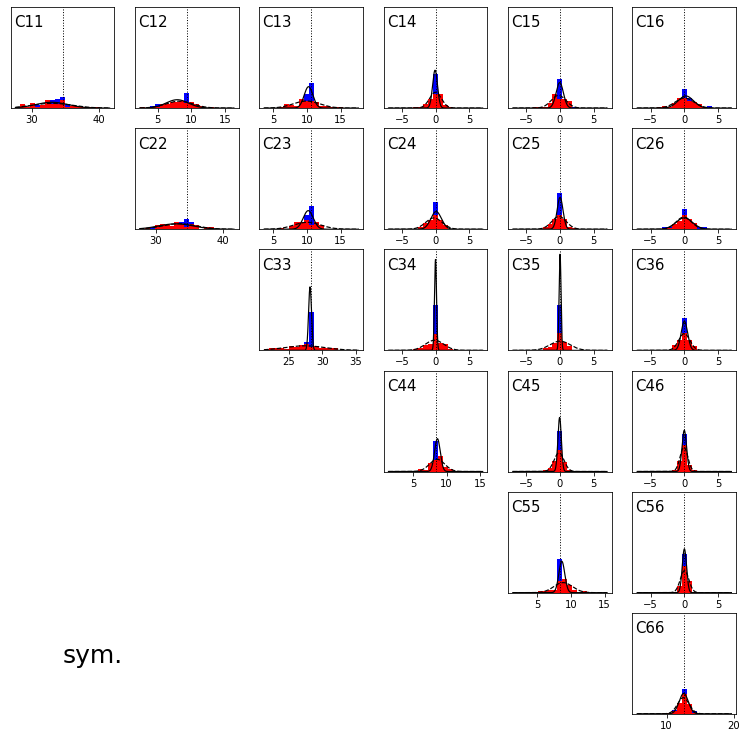

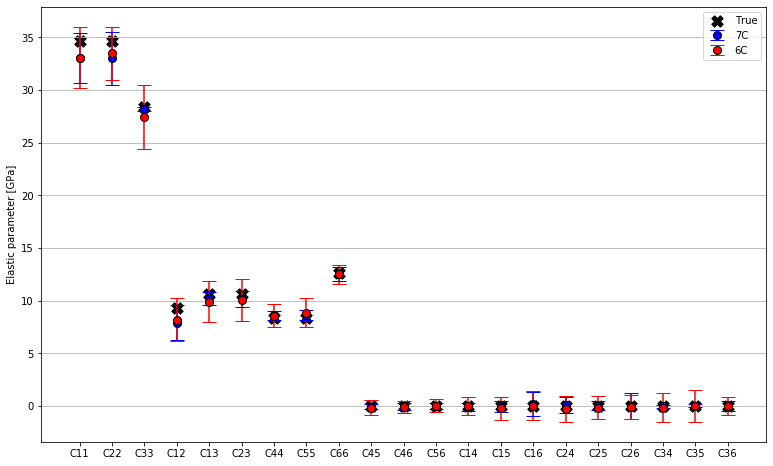

In [26]:
fac = 1e-9 ##conversion to GPa
width = 7.
Nplot = 1000
nbins = 19
save = False
savename = ' '

param = [['C11','C12','C13','C14','C15','C16'],\
         ['C00','C22','C23','C24','C25','C26'],\
         ['C00','C00','C33','C34','C35','C36'],\
         ['C00','C00','C00','C44','C45','C46'],\
         ['C00','C00','C00','C00','C55','C56'],\
         ['C00','C00','C00','C00','C00','C66']]

fig, ax = plt.subplots(ncols=6,nrows=6, figsize=(13,13),sharey=True)

width *= 1e9*fac
    # get rid of potential 'nan' in estimations
i1, i2, i3 = np.shape(C_e)
C_e_stripped = []
for i in range(i1):
    c = 0
    for j in range(i2):
        for k in range(i3):
            if not np.isnan(C_e[i,j,k]) and not C_e[i,j,k]==0.0: c+=1
    if c==36:
        C_e_stripped.append(C_e[i,:,:])
print(str(Ninv - np.shape(C_e_stripped)[0])+' estimates stripped')
C_e_stripped = np.array(C_e_stripped)

i1, i2, i3 = np.shape(C_e2)
C_e2_stripped = []
for i in range(i1):
    c = 0
    for j in range(i2):
        for k in range(i3):
            if not np.isnan(C_e2[i,j,k]) and not C_e2[i,j,k]==0.0: c+=1
    if c==36:
        C_e2_stripped.append(C_e2[i,:,:])
print(str(Ninv - np.shape(C_e2_stripped)[0])+' estimates stripped')
C_e2_stripped = np.array(C_e2_stripped)

mu = np.zeros((6,6))
sig = np.zeros((6,6))
for i in range(0,6):
    for j in range(i,6):
        n = len(C_e_stripped[:,i,j])
        mu[i,j] = 1/n * np.sum(C_e_stripped[:,i,j]*fac) 
        sig[i,j] = 1/n * np.sum((C_e_stripped[:,i,j]*fac-mu[i,j])**2)

mu2 = np.zeros((6,6))
sig2 = np.zeros((6,6))
for i in range(0,6):
    for j in range(i,6):
        n = len(C_e2_stripped[:,i,j])
        mu2[i,j] = 1/n * np.sum(C_e2_stripped[:,i,j]*fac) 
        sig2[i,j] = 1/n * np.sum((C_e2_stripped[:,i,j]*fac-mu2[i,j])**2)
        

for i in range(0,6):
    for j in range(0,6):
        if i<=j:
            hist_range = [C[i,j]*fac-width,C[i,j]*fac+width]
            x = np.linspace(hist_range[0],hist_range[1],Nplot)
            y = 1/np.sqrt(2*np.pi*sig[i,j])*np.e**(-1/(2*sig[i,j])*(x-mu[i,j])**2)
            y2 = 1/np.sqrt(2*np.pi*sig2[i,j])*np.e**(-1/(2*sig2[i,j])*(x-mu2[i,j])**2)
            ax[i,j].hist(C_e_stripped[:,i,j]*fac,bins=nbins,color='blue',density=True, range=hist_range)
            ax[i,j].hist(C_e2_stripped[:,i,j]*fac,bins=nbins,color='red',density=True, range=hist_range)
            ax[i,j].set_yticks([])
            ax[i,j].axvline(C[i,j]*fac,linestyle='dotted',c='black',linewidth=1.)
            #ax[i,j].axvline(mu[i,j],linestyle='dashed',c='black')
            #ax[i,j].axvline(mu2[i,j],linestyle='dashed',c='black')
            ax[i,j].plot(x,y,color='black',linestyle='solid',linewidth=1.2)
            ax[i,j].plot(x,y2,color='black',linestyle='dashed',linewidth=1.2)
            ax[i,j].text(0.03,0.8,param[i][j],transform = ax[i,j].transAxes,fontsize=15)
        else:
            ax[i,j].set_axis_off()
            if i==5 and j==0:
                ax[i,j].text(0.5,0.5,'sym.',transform = ax[i,j].transAxes,fontsize=25)
if save:
    plt.savefig(savename+'_tri.png')
plt.plot()
    
param = ['C11','C22','C33','C12','C13','C23','C44','C55','C66','C45','C46','C56','C14','C15','C16','C24',\
         'C25','C26','C34','C35','C36']
c_true = np.array([C[0,0],C[1,1],C[2,2],C[0,1],C[0,2],C[1,2],C[3,3],C[4,4],C[5,5],C[3,4],C[3,5],C[4,5],C[0,3],C[0,4],\
              C[0,5],C[1,3],C[1,4],C[1,5],C[2,3],C[2,4],C[2,5]])*1e-9
c_est = np.array([mu[0,0],mu[1,1],mu[2,2],mu[0,1],mu[0,2],mu[1,2],mu[3,3],mu[4,4],mu[5,5],mu[3,4],\
             mu[3,5],mu[4,5],mu[0,3],mu[0,4],mu[0,5],mu[1,3],mu[1,4],mu[1,5],mu[2,3],mu[2,4],\
             mu[2,5]])
c_err = np.sqrt(np.array([sig[0,0],sig[1,1],sig[2,2],sig[0,1],sig[0,2],sig[1,2],sig[3,3],sig[4,4],sig[5,5],sig[3,4],\
             sig[3,5],sig[4,5],sig[0,3],sig[0,4],sig[0,5],sig[1,3],sig[1,4],sig[1,5],sig[2,3],sig[2,4],\
             sig[2,5]]))
c_est2 = np.array([mu2[0,0],mu2[1,1],mu2[2,2],mu2[0,1],mu2[0,2],mu2[1,2],mu2[3,3],mu2[4,4],mu2[5,5],mu2[3,4],\
             mu2[3,5],mu2[4,5],mu2[0,3],mu2[0,4],mu2[0,5],mu2[1,3],mu2[1,4],mu2[1,5],mu2[2,3],mu2[2,4],\
             mu2[2,5]])
c_err2 = np.sqrt(np.array([sig2[0,0],sig2[1,1],sig2[2,2],sig2[0,1],sig2[0,2],sig2[1,2],sig2[3,3],sig2[4,4],sig2[5,5],sig2[3,4],\
             sig2[3,5],sig2[4,5],sig2[0,3],sig2[0,4],sig2[0,5],sig2[1,3],sig2[1,4],sig2[1,5],sig2[2,3],sig2[2,4],\
             sig2[2,5]]))

plt.figure(figsize=(13,8))
plt.errorbar(param,c_est,yerr=c_err,label='7C',color='blue',fmt='o',ms=8,capsize=7,mfc='blue',mec='black')
plt.errorbar(param,c_est2,yerr=c_err2,label='6C',color='red',fmt='o',ms=8,capsize=7,mfc='red',mec='black')
plt.scatter(param,c_true,color='black',marker='X',label='True',s=130,edgecolors='black')
plt.grid(axis='y')
plt.ylabel('Elastic parameter [GPa]')
plt.legend(loc=1)
if save:
    plt.savefig(savename+'_err.png')
plt.show()